In [18]:
import numpy as np
import matplotlib.pyplot as plt
import corner
import torch
from functions import chi2_graph

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [19]:
index = 1
data = np.load('../../Data/sample_NuFit0911.npz')
data_all = np.column_stack([data['ve_dune'][:,:36], data['vu_dune'][:,:36], data['vebar_dune'][:,:36], data['vubar_dune'][:,:36]])
flow = torch.load('./nf/{}.pt'.format(index))

In [20]:
n_sample = 1000000
IO_samples = flow.sample(num_samples=n_sample,
            context=torch.tensor(np.array([data_all[0]/1000]), dtype=torch.float32).to(device)).cpu().detach().numpy().reshape(-1, 4)
NO_samples = flow.sample(num_samples=n_sample,
            context=torch.tensor(np.array([data_all[1]/1000]), dtype=torch.float32).to(device)).cpu().detach().numpy().reshape(-1, 4)

In [21]:
np.savez("./contour_IO/nf.npz", IO_samples)
np.savez("./contour_NO/nf.npz", NO_samples)

In [22]:
x, y, X, Y, Z = chi2_graph()

/tmp/ipykernel_340943/3700707105.py:15: UserWarning: No contour levels were found within the data range.
  DUT2 = plot_axis.contour(X, Y, Z, 0, colors='blue', linestyles="-", linewidths=1)


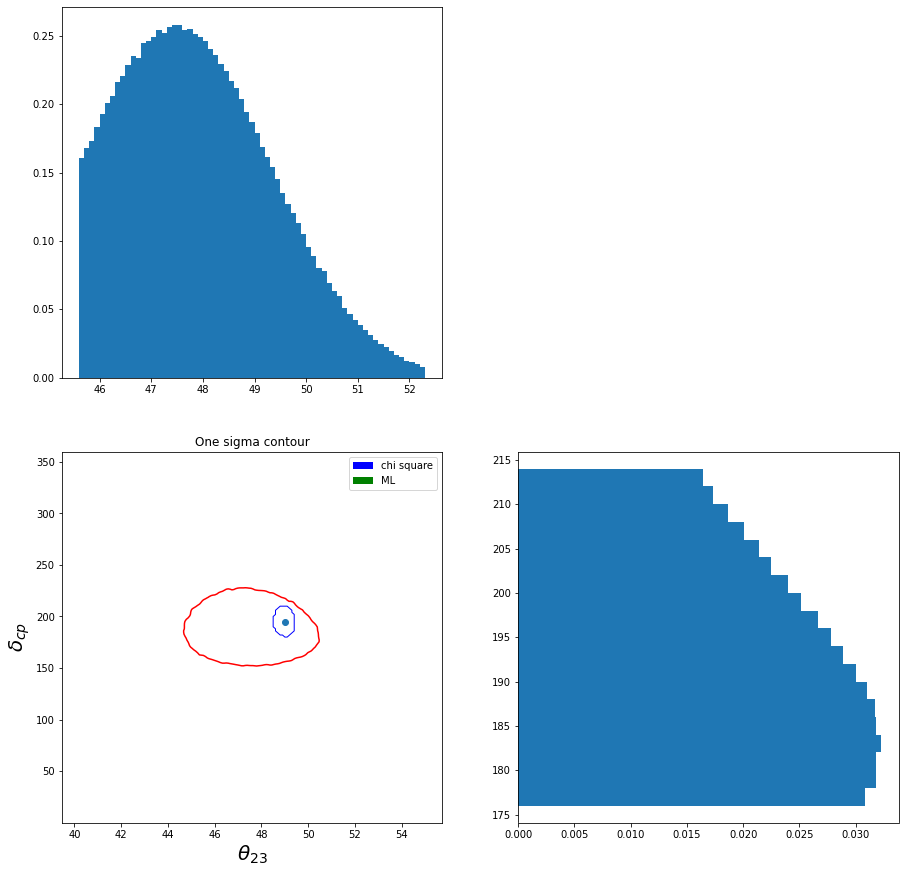

In [25]:
nf_delta = np.angle(IO_samples[:, 2] + 1j*IO_samples[:, 3], deg=True)
nf_delta = np.where(nf_delta > 0 , nf_delta, nf_delta+360)

fig, ax = plt.subplots(1,1, figsize=(15,15))

plot_axis = plt.subplot(2,2,1)
plot_axis.hist(IO_samples[:, 1]*180/np.pi,density=1,bins=x)

plot_axis = plt.subplot(2,2,4)
plot_axis.hist(nf_delta,orientation="horizontal",density=1, bins=y)

plot_axis = plt.subplot(2,2,3)
plot_axis.set_title('One sigma contour')
DUT2 = plot_axis.contour(X, Y, Z, 0, colors='blue', linestyles="-", linewidths=1)
corner.hist2d(IO_samples[:, 1]*180/np.pi, nf_delta,
                    levels=(0.68,),
                    scale_hist=True,
                    plot_datapoints=False,
                    color='red',
                    labels= ["$\\theta_{23} $($^\circ$)", "$\delta_{cp} $($^\circ$)"],
                    plot_contours = True,
                    plot_density = False,
                    fontsize=30,
                    bins = [200, 200],
                    label_kwargs={"fontsize": 30},
                    smooth=True
                   )
plt.scatter(data['theta23'][0], data['delta'][0])
plot_axis.set_xlabel(r'$\theta_{23} $', fontsize=20)
plot_axis.set_ylabel(r'$\delta_{cp} $', fontsize=20)
proxy = [plt.Rectangle((2, 2), 0.0, 3, 90, fc=c) for c in ['blue', 'green']]
plt.legend(proxy, ["chi square", "ML"])
plt.show()